In [ ]:
!pip install numpy matplotlib pillow scikit-learn


Please upload an image file:


Saving kodak_pixpro_fz201_01.jpg to kodak_pixpro_fz201_01.jpg
Uploaded file: kodak_pixpro_fz201_01.jpg


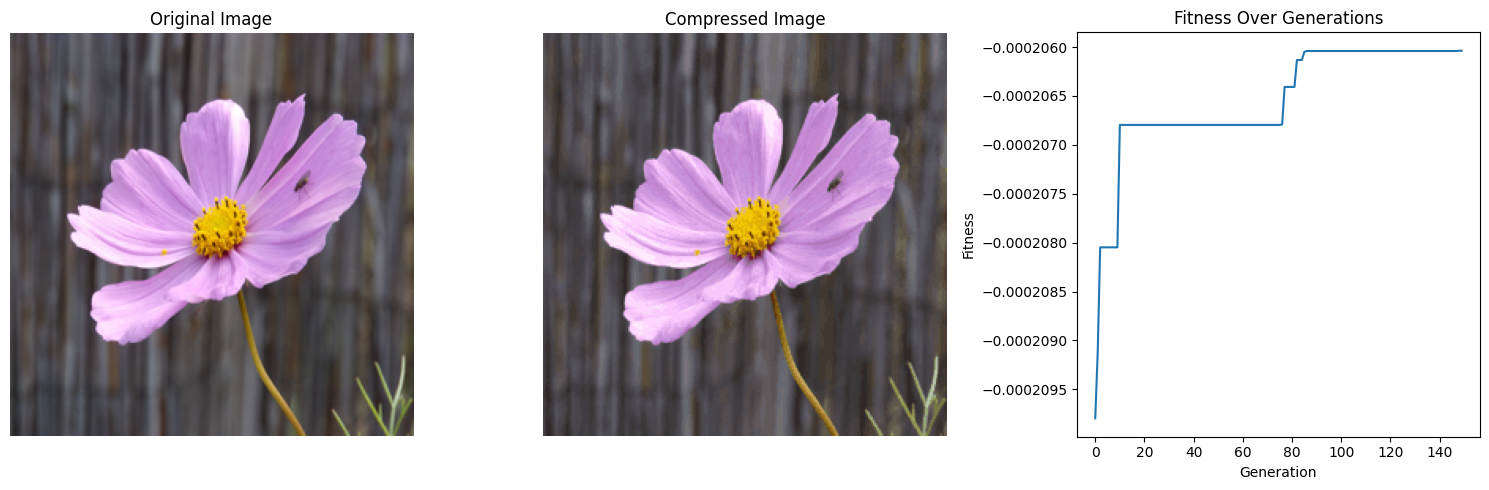


Key Metrics:
Original Image Format: JPEG
Original Image Size (KB): 192.00
Compressed Image Size (KB): 64.19
Reconstruction Error (MSE): 0.000206
Execution Time (s): 1289.96


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from random import randint, random
from google.colab import files
import time

# Function to upload an image
def upload_image():
    print("Please upload an image file:")
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Uploaded file: {filename}")
        return filename

# Load and preprocess the image
def load_image(image_path, size=(256, 256)):
    img = Image.open(image_path)
    original_format = img.format
    img = img.resize(size)
    img = np.array(img) / 255.0  # Normalize pixel values
    return img, original_format

# Flatten the image into a pixel array
def flatten_image(img):
    h, w, c = img.shape
    return img.reshape(-1, c), (h, w, c)

# Reconstruct image from compressed data
def reconstruct_image(flat_pixels, palette, shape):
    indices = np.argmin(np.linalg.norm(flat_pixels[:, None] - palette, axis=2), axis=1)
    return palette[indices].reshape(shape)

# Fitness function: Minimize reconstruction error
def calculate_fitness(flat_pixels, palette):
    reconstructed_pixels = reconstruct_image(flat_pixels, palette, (flat_pixels.shape[0], 3))
    return -mean_squared_error(flat_pixels, reconstructed_pixels)

# Genetic Algorithm operations
def initialize_population(size, k, flat_pixels):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(flat_pixels)
    initial_palette = kmeans.cluster_centers_
    return [initial_palette + np.random.normal(0, 0.005, initial_palette.shape) for _ in range(size)]

def select_parents(population, fitness, num_parents):
    selected_indices = np.argsort(fitness)[-num_parents:]
    return [population[i] for i in selected_indices]

def crossover(parent1, parent2):
    cutoff = randint(1, parent1.shape[0] - 1)
    child = np.vstack((parent1[:cutoff], parent2[cutoff:]))
    return child

def mutate(palette, mutation_rate=0.05):
    if random() < mutation_rate:
        idx = randint(0, palette.shape[0] - 1)
        palette[idx] += np.random.normal(0, 0.01, size=3)
        palette[idx] = np.clip(palette[idx], 0, 1)  # Ensure valid RGB values
    return palette

def genetic_algorithm(flat_pixels, k, population_size=50, generations=100, mutation_rate=0.05):
    population = initialize_population(population_size, k, flat_pixels)
    best_fitness = -float('inf')
    best_palette = None

    fitness_over_time = []
    for generation in range(generations):
        fitness = [calculate_fitness(flat_pixels, palette) for palette in population]
        fitness_over_time.append(max(fitness))

        if max(fitness) > best_fitness:
            best_fitness = max(fitness)
            best_palette = population[np.argmax(fitness)]

        parents = select_parents(population, fitness, population_size // 2)
        offspring = [mutate(crossover(p1, p2), mutation_rate)
                     for p1, p2 in zip(parents[::2], parents[1::2])]

        population = parents + offspring

    return best_palette, fitness_over_time

# Visualization function
def plot_results(original_img, compressed_img, fitness_over_time, metrics):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(compressed_img)
    axes[1].set_title('Compressed Image')
    axes[1].axis('off')

    axes[2].plot(fitness_over_time)
    axes[2].set_title('Fitness Over Generations')
    axes[2].set_xlabel('Generation')
    axes[2].set_ylabel('Fitness')

    plt.tight_layout()
    plt.show()

    print("\nKey Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

# Main function
def main():
    start_time = time.time()

    # Upload and load image
    image_path = upload_image()
    img, img_format = load_image(image_path)

    # Flatten image
    flat_pixels, shape = flatten_image(img)

    # Parameters
    k = 64  # Increased number of colors for better quality
    population_size = 50
    generations = 150  # Increased for better optimization

    # Run Genetic Algorithm
    best_palette, fitness_over_time = genetic_algorithm(flat_pixels, k, population_size, generations)

    # Reconstruct compressed image
    compressed_img = reconstruct_image(flat_pixels, best_palette, shape)

    # Metrics
    reconstruction_error = mean_squared_error(flat_pixels, compressed_img.reshape(-1, 3))
    original_size = img.size / 1024  # in KB
    compressed_size = (k * 3 + len(flat_pixels)) / 1024  # Approximation in KB
    execution_time = time.time() - start_time

    metrics = {
        "Original Image Format": img_format,
        "Original Image Size (KB)": f"{original_size:.2f}",
        "Compressed Image Size (KB)": f"{compressed_size:.2f}",
        "Reconstruction Error (MSE)": f"{reconstruction_error:.6f}",
        "Execution Time (s)": f"{execution_time:.2f}",
    }

    # Visualize results
    plot_results(img, compressed_img, fitness_over_time, metrics)

# Run the code
if __name__ == "__main__":
    main()
